# Propensity Score predicting for matching study

##### This code generates propensity scores used for matching schools in a quasi experimental evaluation

In [4]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN_class
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor as KNN_reg
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
import time
from sklearn.metrics import roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
%matplotlib inline

This script inputs school characteristic datasets for each provider for their Year 2 PSL schools as well as their non PSL potential comparison schools and estimates propensity scores using three different models.

## Defining functions for importing & cleaning

In [3]:
#Imports dataset from Stata
def import_stata(provider):
    provider_df_t=pd.read_stata("/Users/ChristyL/Documents/IDinsight/Social_Finance/Matching_Analysis_Christy/"+provider+"_pool.dta")
    provider_df_t.head()
    
    #Saving school codes separately
    schoolid_provider=provider_df_t.loc[:,['schoolID']]
    provider_df=provider_df_t.loc[:, provider_df_t.columns != 'schoolID']
    
    return provider_df, schoolid_provider

In [4]:
#Function to determine number of missing values
def getPctMissing(series):
    num = series.isnull().sum()
    den=series.shape[0]
    #den = series.count()
    return 100*(num/den)

In [5]:
#Cleans data - changes variable types 
def clean_data(df):

    #Changing var types
    int_cols=['ReadingSpace','books','shelves', 'Otherm_PRI', 'Otherf_PRI', 'Chalkboards_PRI', 'Desks_PRI', 'other_PRI', 'Chairs_PRI', 'Benches_PRI', 'Solid_PRI', 'Semisolid_PRI', 'Makeshift_PRI', 'Partitioned_PRI','OpenAir_PRI']
    for obj in int_cols:
        df[obj] = df[obj].astype('float64')
    teach_cols = [col for col in df.columns if 'Teachers' in col]
    for obj in teach_cols:
        df[obj] = df[obj].astype('float64')
    Rpt_cols = [col for col in df.columns if 'Rpt' in col]
    for obj in Rpt_cols:
        df[obj] = df[obj].astype('float64')
    blind_cols = [col for col in df.columns if 'Blind' in col]
    for obj in blind_cols:
        df[obj] = df[obj].astype('float64')
    entrant_cols = [col for col in df.columns if 'Entrants' in col]
    for obj in entrant_cols:
        df[obj] = df[obj].astype('float64')
    deaf_cols = [col for col in df.columns if 'Deaf' in col]
    for obj in deaf_cols:
        df[obj] = df[obj].astype('float64')
    stu_cols = [col for col in df.columns if 'Students' in col]
    for obj in stu_cols:
        df[obj] = df[obj].astype('float64')
    pupil_cols = [col for col in df.columns if 'pupil' in col]
    for obj in pupil_cols:
        df[obj] = df[obj].astype('float64')
    total_cols = [col for col in df.columns if 'Total' in col]
    for obj in total_cols:
        df[obj] = df[obj].astype('float64')
    obj_columns2= df.select_dtypes(['float32']).columns
    for obj in obj_columns2:
        df[obj] = df[obj].astype('float64')
    obj_columns= df.select_dtypes(['object']).columns
    for obj in obj_columns:
        df[obj] = df[obj].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    to_int=['PSL_treatment','latrine_recode','shared_campus']
    for feature_name in to_int:
        df[feature_name] = df[feature_name].astype(int)
        
 
        
    return df

In [6]:
#Uses KNN to predict missing values
def knn_miss(df):
    df_fill=df.dropna(axis=1,how='any')
    df_complete=df.copy()
    n=df_complete.shape[0]
    for c in df_complete.columns:
        if df_complete[c].count()<n:
            df_filled = df_complete[~df_complete[c].isnull()]
            df_missing=df_complete[df_complete[c].isnull()]
            df_predict=df_missing.copy()


            x_fill=df_filled[df_fill.columns]
            x_fill_std = Standardize(with_mean=False).fit_transform(x_fill)
            x_miss=df_missing[df_fill.columns]
            x_miss_std = Standardize(with_mean=False).fit_transform(x_miss)
            y_fill=df_filled[c]


            knn_class = KNN_class(n_neighbors=5)
            knn_reg = KNN_reg(n_neighbors=5)
            if df_complete[c].dtype == np.dtype('float32'):
                knn_reg.fit(x_fill_std, y_fill)
                df_predict.loc[:, c] = knn_reg.predict(x_miss_std)

            elif df_complete[c].dtype == np.dtype('float64'):
                knn_reg.fit(x_fill_std, y_fill)
                df_predict.loc[:, c] = knn_reg.predict(x_miss_std)

            else:
                print (df_complete[c].dtype)
                knn_class.fit(x_fill, y_fill)
                df_predict.loc[:, c] = knn_class.predict(x_miss)

            df_complete = pd.concat([df_filled, df_predict])


    return df_complete

In [7]:
def encode_test_train(df):
    # Categorical columns for use in one-hot encoder
    df[df < 0] = 0 # turning missing categories to 0 for now
    categorical = (df.dtypes.values != np.dtype('float64'))
    print categorical

    # Get numpy array from data
    x = df.values[:, :-1]
    y = df.values[:, -1]

    # Apply one hot endcoing
    encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
    x = encoder.fit_transform(x)
    x.shape
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=46)

    print x_train.shape
    print y_train.shape
    print x_test.shape
    print y_test.shape
    
    return x, y, x_train, y_train, x_test, y_test

In [22]:
#Merging back in School IDs and exporting final dataset
def export_stata(df_pscore, provider_id, provider):
    #Use final df of pscores
    
    pscores=df_pscore.filter(regex='pscore')
    #Merging back school ID
    final_df=pd.merge(provider_id, pscores, right_index=True, left_index=True)
    

    #Exporting to Stata
    final_df.to_stata("/Users/ChristyL/Documents/IDinsight/Social_Finance/Matching_Analysis_Christy/"+provider+"_pscores.dta")

## Importing data for school provider #1

In [8]:
(bridge,bridge_id)=import_stata('Bridge')

In [9]:
bridge_id.head()

,schoolID
0,60001
1,60002
2,60003
3,60004
4,60005


In [10]:
bridge.head()

,YrEst,ECESchool,PrimarySchool,JHSSchool,SHSSchool,ALPSchool,ABESchool,TVETSchool,Teachers,MaleTeachers,FemaleTeachers,ECETeachers,PrimaryTeachers,JHSTeachers,SHSTeachers,ALPTeachers,ABETeachers,TVETTeachers,QualifiedTeachers,NotqualifiedTeachers,TeacherLevel_Unknown,ECEMaleStudents,ECEFemaleStudents,PrimaryMaleStudents,PrimaryFemaleStudents,JHSMaleStudents,JHSFemaleStudents,SHSMaleStudents,SHSFemaleStudents,TVETMaleStudents,TVETFemaleStudents,AlternateMaleStudents,AlternateFemaleStudents,OnFoot_drySeason,OnFoot_WetSeason,MotorCycle_DrySeason,MotorCycle_WetSeason,Car_DrySeason,Car_WetSeason,UnqualifiedTeachers,bldgSolid,bldgSemi,bldgMakeshift,bldgOpen,bldgOther,Library,Librarian,ReadingSpace,books,shelves,Phone,fenceOrWall,Pipe,handPump,Well,Creek,WaterFacility_NeedsRepair,NoWater,ToiletB,ToiletG,ToiletBG,ToiletM,ToiletF,ToiletMF,Auditorium,Clinic,principalOffice,Farm,StaffRm,HandWashFacility,Garden,ComputerLab,Generator,FuelGenerator,PlayGround,ScienceLab,Storage,Cafeteria,LocalGrid,NatGrid,SupportMOE,MOEamt,SupportLocal,SupportPvt,SupportReligious,SupportComm,SupportNGO,PTA,PTAMtgs,Board,BdMtgs,Books_Support,Books_govt,Books_other,Furn_Support,Furn_govt,Furn_other,Food_Support,Food_govt,Food_other,Supp_Support,Supp_govt,Supp_other,Train_Support,Train_govt,Train_other,Lab_Support,Lab_govt,Lab_other,shift_PRI,Solid_PRI,Semisolid_PRI,Makeshift_PRI,Partitioned_PRI,OpenAir_PRI,other_PRI,Chairs_PRI,Desks_PRI,Benches_PRI,Chalkboards_PRI,National_PRI,pupil_a5m_PRI,pupil_a5f_PRI,pupil_a6m_PRI,pupil_a6f_PRI,pupil_a7m_PRI,pupil_a7f_PRI,pupil_a8m_PRI,pupil_a8f_PRI,pupil_a9m_PRI,pupil_a9f_PRI,pupil_a10m_PRI,pupil_a10f_PRI,pupil_a11m_PRI,pupil_a11f_PRI,Totalm_PRI,Totalf_PRI,Morning_PRI,Afternoon_PRI,Evening_PRI,Rptrsm_PRI,Rptrsf_PRI,Entrantsm_PRI,Entrantsf_PRI,EntrantsECEm_PRI,EntrantsECEf_PRI,Blindm_PRI,Blindf_PRI,Deafm_PRI,Deaff_PRI,Otherm_PRI,Otherf_PRI,tower_distance,road_distance,tot_class,tot_pri_students,prim_ratio,latrine_recode,shared_campus,PSL_treatment
0,2003,Yes,Yes,No,No,No,No,No,2,2,0,1,1,0,0,0,0,0,2,0,0,24,16,24,10,0,0,0,0,0,0,0,0,< 1 minute,NaN,NaN,NaN,NaN,NaN,0,No,No,Yes,No,No,No,No,0,0,0,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0.0,No,No,No,No,No,No,NaN,No,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0,2.0,3.0,3.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,Yes,No,No,0.0,0.0,10.0,5.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,34.0,34.000000,0.0,0.0,0.0
1,1984,Yes,Yes,No,No,No,No,No,7,6,1,4,3,0,0,0,0,0,7,0,0,82,49,55,32,0,0,0,0,0,0,0,0,> 2 hours,> 2 hours,Btwn 15 & 30 minutes,Btwn 30 minutes & 1 hour,< 15 minutes,Btwn 30 minutes & 1 hour,0,No,No,No,No,No,No,No,0,0,0,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,30000.0,No,No,No,No,No,Yes,3.0,Yes,3.0,Yes,Yes,No,No,No,No,Yes,No,Yes,No,No,No,Yes,Yes,No,No,No,No,1,6.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,30.0,6.0,Yes,2.0,0.0,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,Yes,No,No,7.0,3.0,10.0,3.0,10.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,7.182988,1033.128971,6.0,87.0,29.000000,0.0,0.0,0.0
2,1974,Yes,Yes,No,No,No,No,No,4,3,1,4,3,0,0,0,0,0,3,1,0,60,48,60,62,0,0,0,0,0,0,0,0,< 1 minute,< 1 minute,NaN,NaN,NaN,NaN,1,No,Yes,No,No,No,No,NaN,0,0,0,No,No,No,Yes,No,No,No,No,Yes,Yes,No,Yes,Yes,No,No,No,Yes,No,No,Yes,No,No,No,No,No,No,Yes,No,No,No,Yes,29110.0,NaN,NaN,NaN,NaN,NaN,Yes,4.0,Yes,4.0,Yes,Yes,No,NaN,No,No,Yes,No,Yes,Yes,Yes,No,Yes,No,Yes,NaN,No,No,1,0.0,6.0,0.0,0.0,0.0,0.0,8.0,65.0,0.0,6.0,Yes,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0,2.0,8.0,6.0,Yes,No,No,37.0,48.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,6.979019,84.568957,6.0,122.0,40.666668,1.0,0.0,0.0
3,1968,Yes,Yes,Yes,No,No,No,No,5,3,2,3,3,2,0,0,0,0,2,3,0,84,56,61,36,26,25,0,0,0,0,0,0,NaN,NaN,Btwn 15 & 30 minutes,Btwn 15 & 30 minutes,Btwn 15 & 30 minutes,Btwn 15 & 30 minutes,3,No,No,Yes,No,No,No,No,0,0,0,Yes,No,No,Yes,No,No,No,No,Yes,Yes,No,Yes,Yes,N

In [11]:
bridge_clean=clean_data(bridge)

In [12]:
bridge_clean.head()

,YrEst,ECESchool,PrimarySchool,JHSSchool,SHSSchool,ALPSchool,ABESchool,TVETSchool,Teachers,MaleTeachers,...,Deaff_PRI,Otherm_PRI,Otherf_PRI,tower_distance,tot_class,tot_pri_students,prim_ratio,latrine_recode,shared_campus,PSL_treatment
0,2003,1,0,0,0,0,0,0,2.0,2.0,...,0.0,0.0,0.0,NaN,0.0,34.0,34.000000,0,0,0
1,1984,1,0,0,0,0,0,0,7.0,6.0,...,0.0,1.0,1.0,7.182988,6.0,87.0,29.000000,0,0,0
2,1974,1,0,0,0,0,0,0,4.0,3.0,...,0.0,2.0,0.0,6.979019,6.0,122.0,40.666668,1,0,0
3,1968,1,0,1,0,0,0,0,5.0,3.0,...,0.0,0.0,0.0,25.888776,6.0,97.0,32.333332,1,1,0
4,1964,1,0,0,0,0,0,0,4.0,3.0,...,0.0,0.0,0.0,8.605487,3.0,86.0,28.666666,1,0,0


In [12]:
bridge_fill=knn_miss(bridge_clean)

In [13]:
getPctMissing(bridge_fill)

YrEst                        0.0
ECESchool                    0.0
PrimarySchool                0.0
JHSSchool                    0.0
SHSSchool                    0.0
ALPSchool                    0.0
ABESchool                    0.0
TVETSchool                   0.0
Teachers                     0.0
MaleTeachers                 0.0
FemaleTeachers               0.0
ECETeachers                  0.0
PrimaryTeachers              0.0
JHSTeachers                  0.0
SHSTeachers                  0.0
ALPTeachers                  0.0
ABETeachers                  0.0
TVETTeachers                 0.0
QualifiedTeachers            0.0
NotqualifiedTeachers         0.0
TeacherLevel_Unknown         0.0
ECEMaleStudents              0.0
ECEFemaleStudents            0.0
PrimaryMaleStudents          0.0
PrimaryFemaleStudents        0.0
JHSMaleStudents              0.0
JHSFemaleStudents            0.0
SHSMaleStudents              0.0
SHSFemaleStudents            0.0
TVETMaleStudents             0.0
TVETFemale

In [15]:
(x_br, y_br, x_train_br, y_train_br, x_test_br, y_test_br)=encode_test_train(bridge_fill)

[ True  True  True  True  True  True  True  True False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False  True  True  True
  True  True  True False  True  True  True  True  True  True  True False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True False  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False  True  True  True False False False False
 False False False False False False False False False False False False
 False  True  True  True]
(660, 358)
(660,)
(284, 3

In [309]:
x_br.shape

(944, 357)

## Training Lasso & RF models code

In [34]:
##Training Lasso model
#Uses cross-validation to select lambda and then fits lasso using best lambda
def lasso_train(min_lambda, max_lambda, x, y):
    # Parameters for tuning
    #regularization = 10. ** np.arange(min_lambda, max_lambda)
    regularization=np.logspace(min_lambda, max_lambda, 50)

    #Standardizing data
    std = Standardize(with_mean=False)
    x_std = std.fit_transform(x)

    # To keep track of the best model
    best_score = 0

    # Run grid search for model with 5-fold cross validation
    print '3-fold cross validation:'

    cv = []

    for C in regularization:
        # Cross validation for every experiment
        k_folds = KFold(x.shape[0], n_folds=3, shuffle=True)
        tot_scores = []
        class0_score = []
        class1_score = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_std[train_indices]
            y_train_cv = y[train_indices]
            # Generate validation data
            x_validate = x_std[validation_indices]
            y_validate = y[validation_indices]

            # Fit weighted logit on training data
            wlogit=LogisticRegression(class_weight='balanced',penalty='l1',C=C)
            wlogit.fit(x_train_cv, y_train_cv)
            # Score on validation data
            tot_scores += [wlogit.score(x_validate, y_validate)]
            class0_score += [wlogit.score(x_validate[y_validate==0], y_validate[y_validate==0])]
            class1_score += [wlogit.score(x_validate[y_validate==1], y_validate[y_validate==1])]


        # Record and report accuracy
        tot_average_score = np.mean(tot_scores)
        class0_avg = np.mean(class0_score)
        class1_avg = np.mean(class1_score)
        print "C:", C, "Overall Score:", tot_average_score, "Control:", class0_avg, "Treatment:", class1_avg

        cv.append(class1_avg)


        # Update our record of the best parameters see so far
        if class1_avg > best_score:
            best_score = class1_avg
            best_C = C


    print 'Chosen number of C:', best_C
    print 'Best accuracy:', best_score



    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.semilogx(regularization, (cv), c='b', label='CV score')



    ax.set_xlabel('Regularization parameter $\lambda$')
    ax.set_ylabel('CV score')

    #ax.set_ylim((test_r_squared_plain-0.2, 1.2))
    ax.legend(loc = 'best')

    plt.show()
    
    final_lasso=LogisticRegression(class_weight='balanced',penalty='l1',C=best_C)
    final_lasso.fit(x_std,y)
    
    return final_lasso

In [17]:
def plot_pscore(df,x, model,name,lasso=False):
    df_copy=df.copy()
    
    if lasso==True:
        std = Standardize(with_mean=False)
        x_std = std.fit_transform(x)
        df_copy['pscore_'+str(name)] = model.predict_proba(x_std)[:, 1]
    
    else:
        df_copy['pscore_'+str(name)] = model.predict_proba(x)[:, 1]
    
    treat=df_copy[df_copy['PSL_treatment']==1]
    control=df_copy[df_copy['PSL_treatment']==0]

    bins = np.linspace(0, 1, 100)

    plt.hist(treat['pscore_'+str(name)], bins, alpha=0.5, label='treat')
    plt.hist(control['pscore_'+str(name)], bins, alpha=0.5, label='control')
    plt.legend(loc='upper right')
    plt.title('Propensity scores for '+str(name))
    plt.show()
    
    return df_copy

### Propensity Scores for Bridge

3-fold cross validation:
C: 1e-10 Overall Score: 0.95552741191 Control: 1.0 Treatment: 0.0
C: 2.5595479227e-10 Overall Score: 0.955510525723 Control: 1.0 Treatment: 0.0
C: 6.5512855686e-10 Overall Score: 0.955504896994 Control: 1.0 Treatment: 0.0
C: 1.67683293681e-09 Overall Score: 0.955504896994 Control: 1.0 Treatment: 0.0
C: 4.29193426013e-09 Overall Score: 0.955504896994 Control: 1.0 Treatment: 0.0
C: 1.09854114199e-08 Overall Score: 0.955476753349 Control: 1.0 Treatment: 0.0
C: 2.81176869797e-08 Overall Score: 0.955510525723 Control: 1.0 Treatment: 0.0
C: 7.19685673001e-08 Overall Score: 0.955533040639 Control: 1.0 Treatment: 0.0
C: 1.84206996933e-07 Overall Score: 0.955516154452 Control: 1.0 Treatment: 0.0
C: 4.71486636346e-07 Overall Score: 0.955504896994 Control: 1.0 Treatment: 0.0
C: 1.20679264064e-06 Overall Score: 0.955533040639 Control: 1.0 Treatment: 0.0
C: 3.08884359648e-06 Overall Score: 0.955488010807 Control: 1.0 Treatment: 0.0
C: 7.90604321091e-06 Overall Score: 0.9555

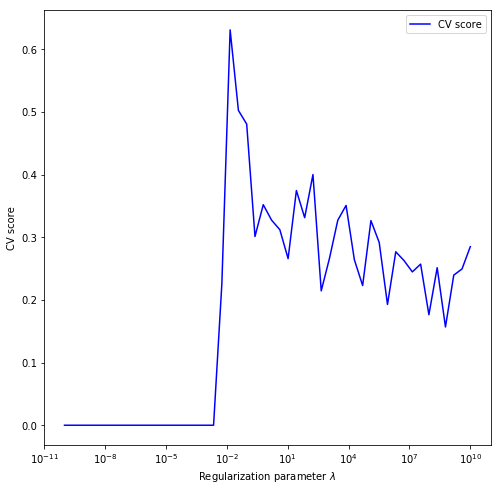

In [18]:
bridge_lass=lasso_train(-10,10,x_br,y_br)

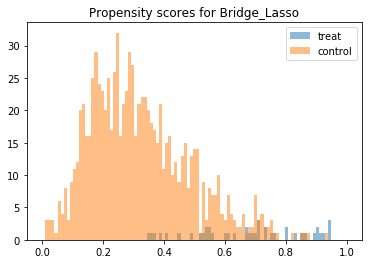

In [19]:
bridge_pscore=plot_pscore(bridge_fill,x_br, bridge_lass ,'Bridge_Lasso',lasso=True)

In [287]:
bridge_pscore.head()

,YrEst,ECESchool,PrimarySchool,JHSSchool,SHSSchool,ALPSchool,ABESchool,TVETSchool,Teachers,MaleTeachers,FemaleTeachers,ECETeachers,PrimaryTeachers,JHSTeachers,SHSTeachers,ALPTeachers,ABETeachers,TVETTeachers,QualifiedTeachers,NotqualifiedTeachers,TeacherLevel_Unknown,ECEMaleStudents,ECEFemaleStudents,PrimaryMaleStudents,PrimaryFemaleStudents,JHSMaleStudents,JHSFemaleStudents,SHSMaleStudents,SHSFemaleStudents,TVETMaleStudents,TVETFemaleStudents,AlternateMaleStudents,AlternateFemaleStudents,OnFoot_drySeason,OnFoot_WetSeason,MotorCycle_DrySeason,MotorCycle_WetSeason,Car_DrySeason,Car_WetSeason,UnqualifiedTeachers,bldgSolid,bldgSemi,bldgMakeshift,bldgOpen,bldgOther,Library,Librarian,ReadingSpace,books,shelves,Phone,fenceOrWall,Pipe,handPump,Well,Creek,WaterFacility_NeedsRepair,NoWater,ToiletB,ToiletG,ToiletBG,ToiletM,ToiletF,ToiletMF,Auditorium,Clinic,principalOffice,Farm,StaffRm,HandWashFacility,Garden,ComputerLab,Generator,FuelGenerator,PlayGround,ScienceLab,Storage,Cafeteria,LocalGrid,NatGrid,SupportMOE,MOEamt,SupportLocal,SupportPvt,SupportReligious,SupportComm,SupportNGO,PTA,PTAMtgs,Board,BdMtgs,Books_Support,Books_govt,Books_other,Furn_Support,Furn_govt,Furn_other,Food_Support,Food_govt,Food_other,Supp_Support,Supp_govt,Supp_other,Train_Support,Train_govt,Train_other,Lab_Support,Lab_govt,Lab_other,shift_PRI,Solid_PRI,Semisolid_PRI,Makeshift_PRI,Partitioned_PRI,OpenAir_PRI,other_PRI,Chairs_PRI,Desks_PRI,Benches_PRI,Chalkboards_PRI,National_PRI,a5m_PRI,a5f_PRI,a6m_PRI,a6f_PRI,a7m_PRI,a7f_PRI,a8m_PRI,a8f_PRI,a9m_PRI,a9f_PRI,a10m_PRI,a10f_PRI,a11m_PRI,a11f_PRI,Totalm_PRI,Totalf_PRI,Morning_PRI,Afternoon_PRI,Evening_PRI,Rptrsm_PRI,Rptrsf_PRI,Entrantsm_PRI,Entrantsf_PRI,EntrantsECEm_PRI,EntrantsECEf_PRI,Blindm_PRI,Blindf_PRI,Deafm_PRI,Deaff_PRI,Otherm_PRI,Otherf_PRI,tower_distance,tot_class,tot_pri_students,prim_ratio,latrine_recode,shared_campus,PSL_treatment,pscoreBridge Lasso
1,1984,1,0,0,0,0,0,0,7.0,6.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0,82.0,49.0,55.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,3,4,2,4,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30000.0,0,0,0,0,0,1,3.0,1,3.0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,6.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,30.0,6.0,1,2.0,0.0,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,1,0,0,7.0,3.0,10.0,3.0,10.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,7.182988,6.0,87.0,29.000000,0,0,0,0.356650
2,1974,1,0,0,0,0,0,0,4.0,3.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0,60.0,48.0,60.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,1.0,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,29110.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0.0,6.0,0.0,0.0,0.0,0.0,8.0,65.0,0.0,6.0,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0,2.0,8.0,6.0,1,0,0,37.0,48.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,6.979019,6.0,122.0,40.666668,1,0,0,0.998463
4,1964,1,0,0,0,0,0,0,4.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0,24.0,24.0,45.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,4,0,0,3.0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,29512.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,3.0,0.0,0.0,0.0,0.0,0.0,120.0,3.0,0.0,3.0,1,0.0,0.0,2.0,2.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,8.0,1,0,0,3.0,2.0,10.0,8.0,10.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,8.605487,3.0,86.0,28.666666,1,0,0,0.376623
5,1962,1,0,1,0,0,0,0,20.0,17.0,3.0,4.0,18.0,8.0,0.0,0.0,0.0,0.0,14.0,6.0,0,81.0,75.0,133.0,86.0,21.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,5,2,6.0,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,72500.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,4.0,1,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,3.0,2.0,6.0,4.0,3.0,3.0,25.0,20.0,1,0,0,7.0,3.0,25.0,20.0,25.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101079,4.0,219.0,12.166667,0,1,0,0.492012
7,1999,1,0,0,0,0,0,0,7.0,6.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0,

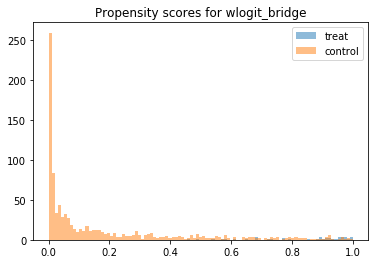

0.891949152542


In [291]:
##Logistic regression - no regularization
std = Standardize(with_mean=False)
x_br_std = std.fit_transform(x_br)
x_train_br_std = std.fit_transform(x_train_br)
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_br, y_br)
bridge_pscore=plot_pscore(bridge_pscore,x_br, weighted_logistic ,'wlogit_bridge')
print(weighted_logistic.score(x_br, y_br))

In [20]:
bridge_pscore.head()

,YrEst,ECESchool,PrimarySchool,JHSSchool,SHSSchool,ALPSchool,ABESchool,TVETSchool,Teachers,MaleTeachers,FemaleTeachers,ECETeachers,PrimaryTeachers,JHSTeachers,SHSTeachers,ALPTeachers,ABETeachers,TVETTeachers,QualifiedTeachers,NotqualifiedTeachers,TeacherLevel_Unknown,ECEMaleStudents,ECEFemaleStudents,PrimaryMaleStudents,PrimaryFemaleStudents,JHSMaleStudents,JHSFemaleStudents,SHSMaleStudents,SHSFemaleStudents,TVETMaleStudents,TVETFemaleStudents,AlternateMaleStudents,AlternateFemaleStudents,OnFoot_drySeason,OnFoot_WetSeason,MotorCycle_DrySeason,MotorCycle_WetSeason,Car_DrySeason,Car_WetSeason,UnqualifiedTeachers,bldgSolid,bldgSemi,bldgMakeshift,bldgOpen,bldgOther,Library,Librarian,ReadingSpace,books,shelves,Phone,fenceOrWall,Pipe,handPump,Well,Creek,WaterFacility_NeedsRepair,NoWater,ToiletB,ToiletG,ToiletBG,ToiletM,ToiletF,ToiletMF,Auditorium,Clinic,principalOffice,Farm,StaffRm,HandWashFacility,Garden,ComputerLab,Generator,FuelGenerator,PlayGround,ScienceLab,Storage,Cafeteria,LocalGrid,NatGrid,SupportMOE,MOEamt,SupportLocal,SupportPvt,SupportReligious,SupportComm,SupportNGO,PTA,PTAMtgs,Board,BdMtgs,Books_Support,Books_govt,Books_other,Furn_Support,Furn_govt,Furn_other,Food_Support,Food_govt,Food_other,Supp_Support,Supp_govt,Supp_other,Train_Support,Train_govt,Train_other,Lab_Support,Lab_govt,Lab_other,shift_PRI,Solid_PRI,Semisolid_PRI,Makeshift_PRI,Partitioned_PRI,OpenAir_PRI,other_PRI,Chairs_PRI,Desks_PRI,Benches_PRI,Chalkboards_PRI,National_PRI,pupil_a5m_PRI,pupil_a5f_PRI,pupil_a6m_PRI,pupil_a6f_PRI,pupil_a7m_PRI,pupil_a7f_PRI,pupil_a8m_PRI,pupil_a8f_PRI,pupil_a9m_PRI,pupil_a9f_PRI,pupil_a10m_PRI,pupil_a10f_PRI,pupil_a11m_PRI,pupil_a11f_PRI,Totalm_PRI,Totalf_PRI,Morning_PRI,Afternoon_PRI,Evening_PRI,Rptrsm_PRI,Rptrsf_PRI,Entrantsm_PRI,Entrantsf_PRI,EntrantsECEm_PRI,EntrantsECEf_PRI,Blindm_PRI,Blindf_PRI,Deafm_PRI,Deaff_PRI,Otherm_PRI,Otherf_PRI,tower_distance,road_distance,tot_class,tot_pri_students,prim_ratio,latrine_recode,shared_campus,PSL_treatment,pscore_Bridge_Lasso
1,1984,1,0,0,0,0,0,0,7.0,6.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0,82.0,49.0,55.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,3,4,2,4,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30000.0,0,0,0,0,0,1,3.0,1,3.0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,6.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,30.0,6.0,1,2.0,0.0,3.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,1,0,0,7.0,3.0,10.0,3.0,10.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,7.182988,1033.128971,6.0,87.0,29.000000,0,0,0,0.380875
2,1974,1,0,0,0,0,0,0,4.0,3.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0,60.0,48.0,60.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,1.0,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,29110.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0.0,6.0,0.0,0.0,0.0,0.0,8.0,65.0,0.0,6.0,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0,2.0,8.0,6.0,1,0,0,37.0,48.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,6.979019,84.568957,6.0,122.0,40.666668,1,0,0,0.488790
4,1964,1,0,0,0,0,0,0,4.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0,24.0,24.0,45.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,4,0,0,3.0,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,29512.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,3.0,0.0,0.0,0.0,0.0,0.0,120.0,3.0,0.0,3.0,1,0.0,0.0,2.0,2.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,8.0,1,0,0,3.0,2.0,10.0,8.0,10.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,8.605487,5052.776190,3.0,86.0,28.666666,1,0,0,0.361236
5,1962,1,0,1,0,0,0,0,20.0,17.0,3.0,4.0,18.0,8.0,0.0,0.0,0.0,0.0,14.0,6.0,0,81.0,75.0,133.0,86.0,21.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,5,2,6.0,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,72500.0,0,0,0,0,0,1,4.0,1,4.0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,4.0,1,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,3.0,2.0,6.0,4.0,3.0,3.0,25.0,20.0,1,0,0,7.0,3.0,25.0,20.0,25.0,20.0,0.0,0.

## Training Random Forest

In [32]:
#Bridge Random Forest
rfc = RandomForest(n_jobs=-1, oob_score = True) 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf}

CV_rfc_br = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc_br.fit(x_br, y_br)

print CV_rfc_br.best_params_

{'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 1}


In [91]:
#Fitting w. new parameters
rfc_bridge = RandomForest(n_estimators=50, max_depth=5, max_features='sqrt', min_samples_leaf = 1)
rfc_bridge.fit(x_br, y_br)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

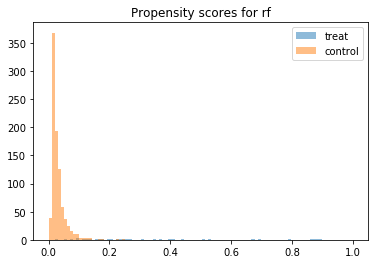

In [95]:
bridge_pscore=plot_pscore(bridge_fill, x_br, rfc_bridge ,'rf',lasso=True)

In [23]:
#Exporting Bridge data
export_stata(bridge_pscore, bridge_id, "Bridge")